# VGG

# LIBRARIES

In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
import keras
from keras.utils import image_dataset_from_directory
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, Input, Rescaling, BatchNormalization
from keras.regularizers import L2
from keras.models import Sequential
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt

2022-11-02 10:44:02.206388: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

# CONSTANTS

In [3]:
BATCH_SIZE = 64
EPOCHS = 90
WIDTH = 224
HEIGHT = 224
CHANNELS = 3
INPUT_SHAPE = (WIDTH, HEIGHT, CHANNELS)
PATH_DATASET_TRAIN = '/mnt/files/Datasets/cats-dogs/training_set/'
PATH_DATASET_TEST = '/mnt/files/Datasets/cats-dogs/test_set/'

# DATASET

## train

In [4]:
train_ds = image_dataset_from_directory(directory=PATH_DATASET_TRAIN,
                                        seed=123,
                                        image_size=(WIDTH, HEIGHT),
                                        color_mode='rgb',
                                        batch_size=BATCH_SIZE)

Found 8000 files belonging to 2 classes.


In [5]:
test_ds = image_dataset_from_directory(directory=PATH_DATASET_TEST,
                                       seed=123,
                                       image_size=(WIDTH, HEIGHT),
                                       color_mode='rgb',
                                       batch_size=BATCH_SIZE)

Found 2000 files belonging to 2 classes.


In [6]:
# Checking if the classes are the same
#assert train_ds.class_names == validation_ds.class_names == test_ds.class_names
class_names = train_ds.class_names

## examples

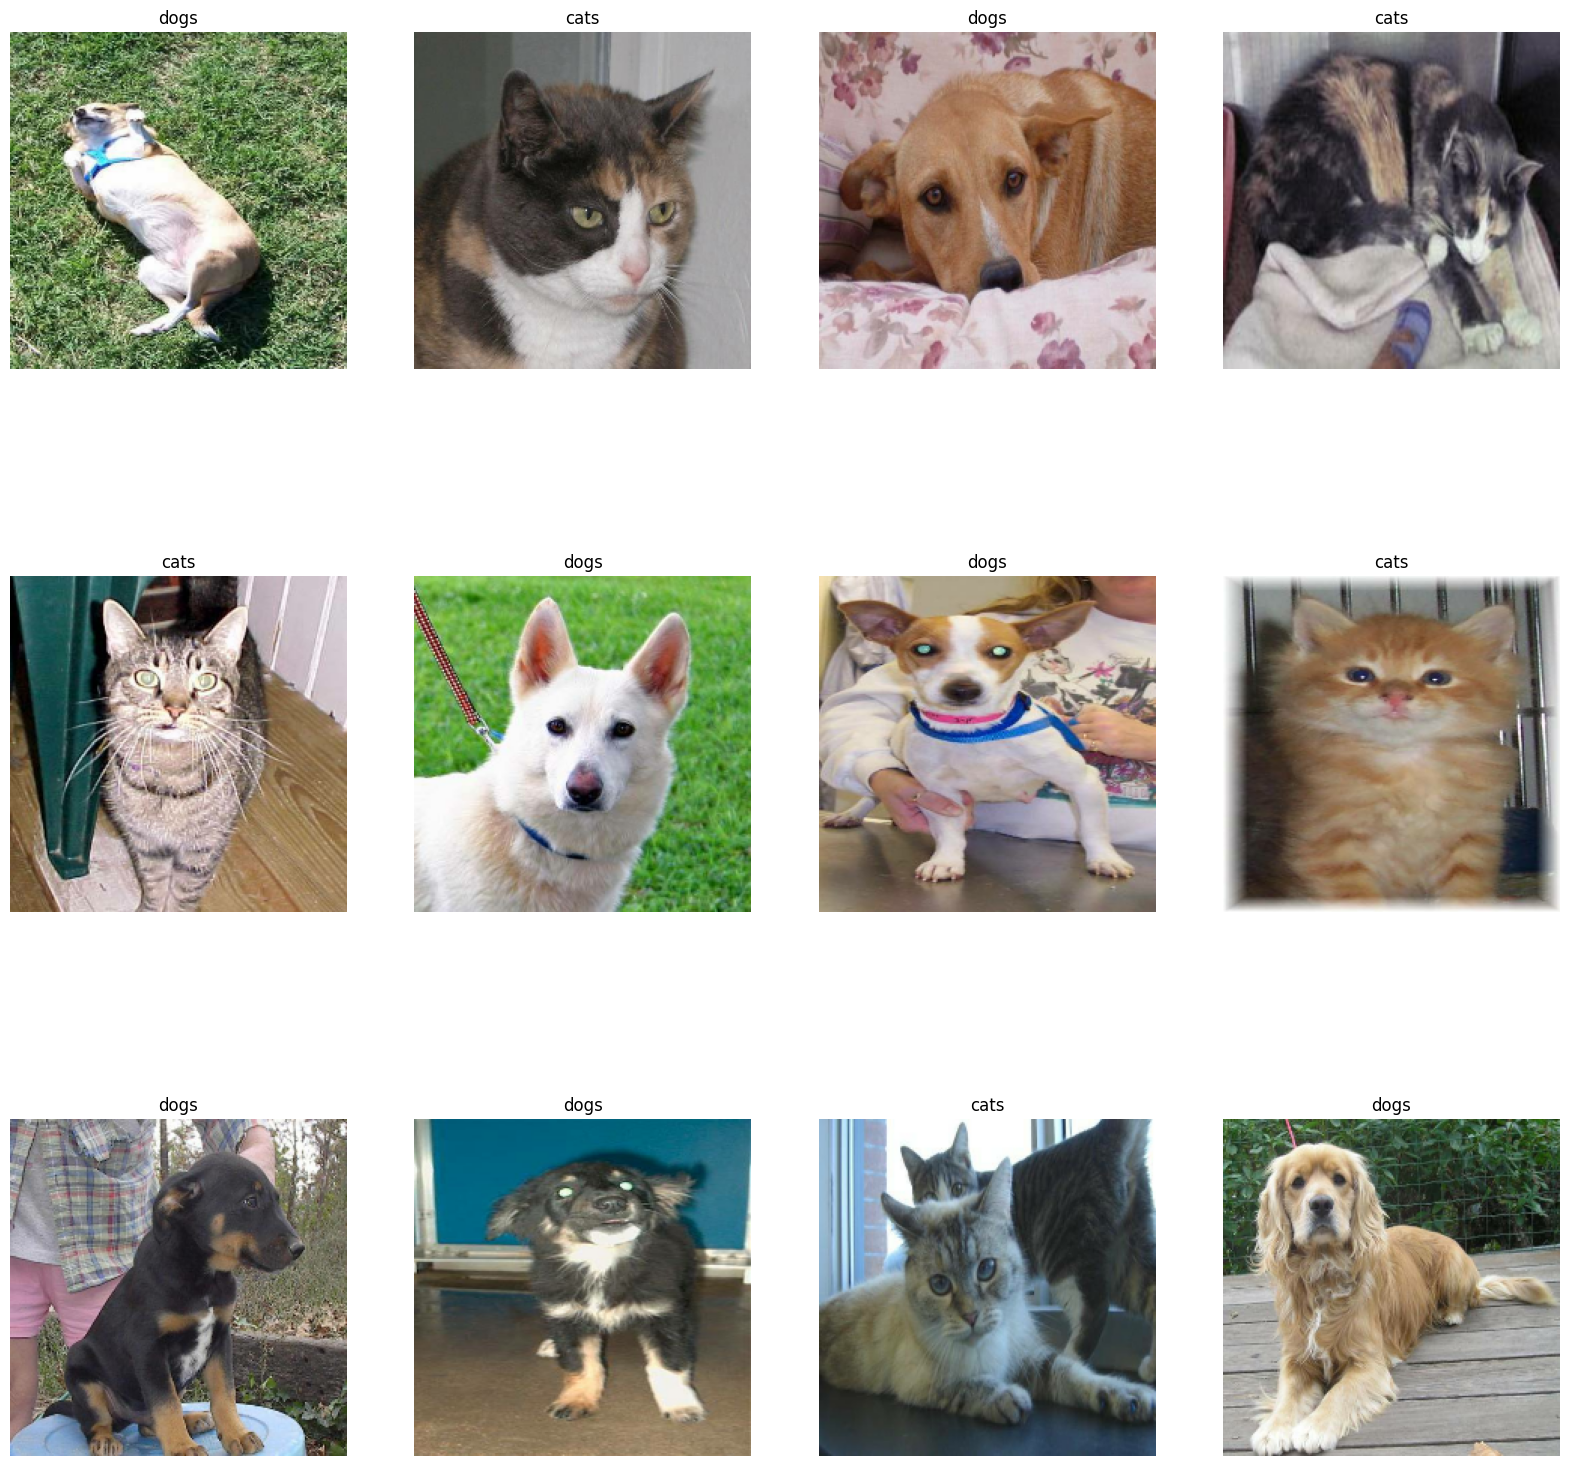

In [7]:
plt.figure(figsize=(20, 20))

for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

## Configure the dataset for performance

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# MODEL 

In [9]:
# DISCLAIMER. THIS IS VGG MODEL A

model = Sequential([
    Input(shape=(WIDTH, HEIGHT, CHANNELS)),
    Rescaling(scale=1./255),
    # block #1
    Conv2D(filters=64, kernel_size=(3, 3), 
           strides=(1, 1), 
           activation='relu', 
           padding='same', 
           input_shape=INPUT_SHAPE),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    BatchNormalization(),
    
    # block #2
    Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=L2(0.0005)),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    BatchNormalization(),
    
    # block #3
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=L2(0.0005)), 
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=L2(0.0005)),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    BatchNormalization(),
    
    # block #4
    
    Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=L2(0.0005)),
    Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=L2(0.0005)),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    BatchNormalization(),
    
    # block #5
    
    Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=L2(0.0005)),
    Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', kernel_regularizer=L2(0.0005)),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    BatchNormalization(),
    
    # flatten
    Flatten(),
    
    # FC
    Dense(units=256, activation='relu'),  # Original: 4096
    Dropout(0.5),
    Dense(units=64, activation='relu'),  # Original: 4096
    Dropout(0.5),
    Dense(units=len(class_names), activation='softmax')  # Original: 1000
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0

# CALLBACKS

In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1)

checkpoint_filepath = '/tmp/checkpoint/model-{epoch:03d}-{val_accuracy:03f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks = [reduce_lr, model_checkpoint_callback]

# OPTIMIZER

In [12]:
optimizer = SGD(learning_rate=0.01, momentum=0.9)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# COMPILE

In [13]:
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# TRAINING

In [15]:
history = model.fit(train_ds, 
                    validation_data=test_ds, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=callbacks, 
                    verbose=1)

Epoch 1/90
125/125 [==============================] - 53s 427ms/step - loss: 1.9647 - accuracy: 0.5340 - val_loss: 1.9410 - val_accuracy: 0.5350 - lr: 0.0100
Epoch 2/90
125/125 [==============================] - 54s 428ms/step - loss: 1.9270 - accuracy: 0.5429 - val_loss: 1.9115 - val_accuracy: 0.5215 - lr: 0.0100
Epoch 3/90
125/125 [==============================] - 53s 425ms/step - loss: 1.8851 - accuracy: 0.5704 - val_loss: 1.8674 - val_accuracy: 0.5620 - lr: 0.0100
Epoch 4/90
125/125 [==============================] - 53s 426ms/step - loss: 1.8549 - accuracy: 0.5790 - val_loss: 1.8243 - val_accuracy: 0.5935 - lr: 0.0100
Epoch 5/90
125/125 [==============================] - 53s 426ms/step - loss: 1.8084 - accuracy: 0.6080 - val_loss: 1.7773 - val_accuracy: 0.6145 - lr: 0.0100
Epoch 6/90
125/125 [==============================] - 53s 425ms/step - loss: 1.7589 - accuracy: 0.6264 - val_loss: 1.7506 - val_accuracy: 0.6130 - lr: 0.0100
Epoch 7/90
125/125 [==============================] 

# EVALUATING

In [16]:
model.load_weights('/tmp/checkpoint/model-082-0.881000.h5')  # Loading the best modelS

In [17]:
model.evaluate(test_ds)

32/32 [==============================] - 3s 90ms/step - loss: 1.1301 - accuracy: 0.8810


[1.1301007270812988, 0.8809999823570251]

## Curves

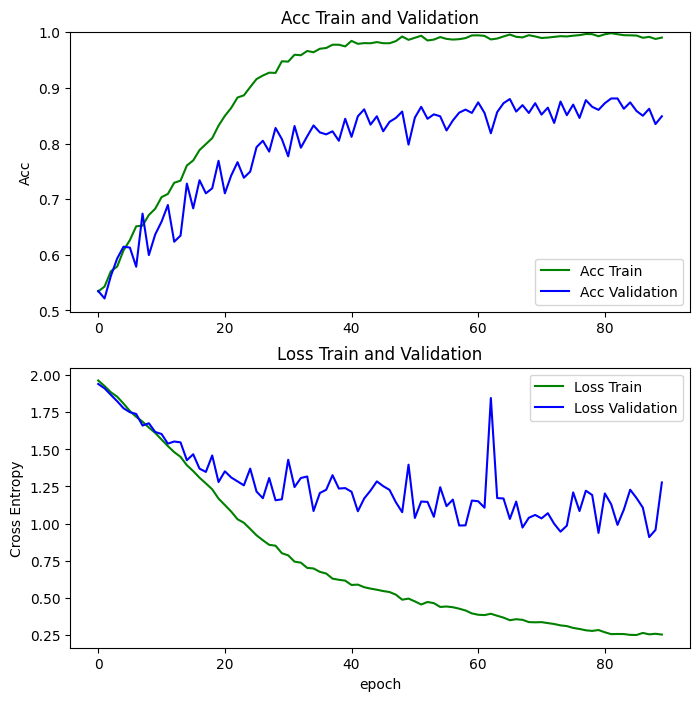

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, 'g', label='Acc Train')
plt.plot(val_acc, 'b', label='Acc Validation')
plt.legend(loc='lower right')
plt.ylabel('Acc')
plt.ylim([min(plt.ylim()),1.001])
plt.title('Acc Train and Validation')

plt.subplot(2, 1, 2)
plt.plot(loss, 'g', label='Loss Train')
plt.plot(val_loss, 'b', label='Loss Validation')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Loss Train and Validation')
plt.xlabel('epoch')
plt.show()

## Infering some examples (green = correct, red = wrong)

2/2 [==============================] - 1s 9ms/step


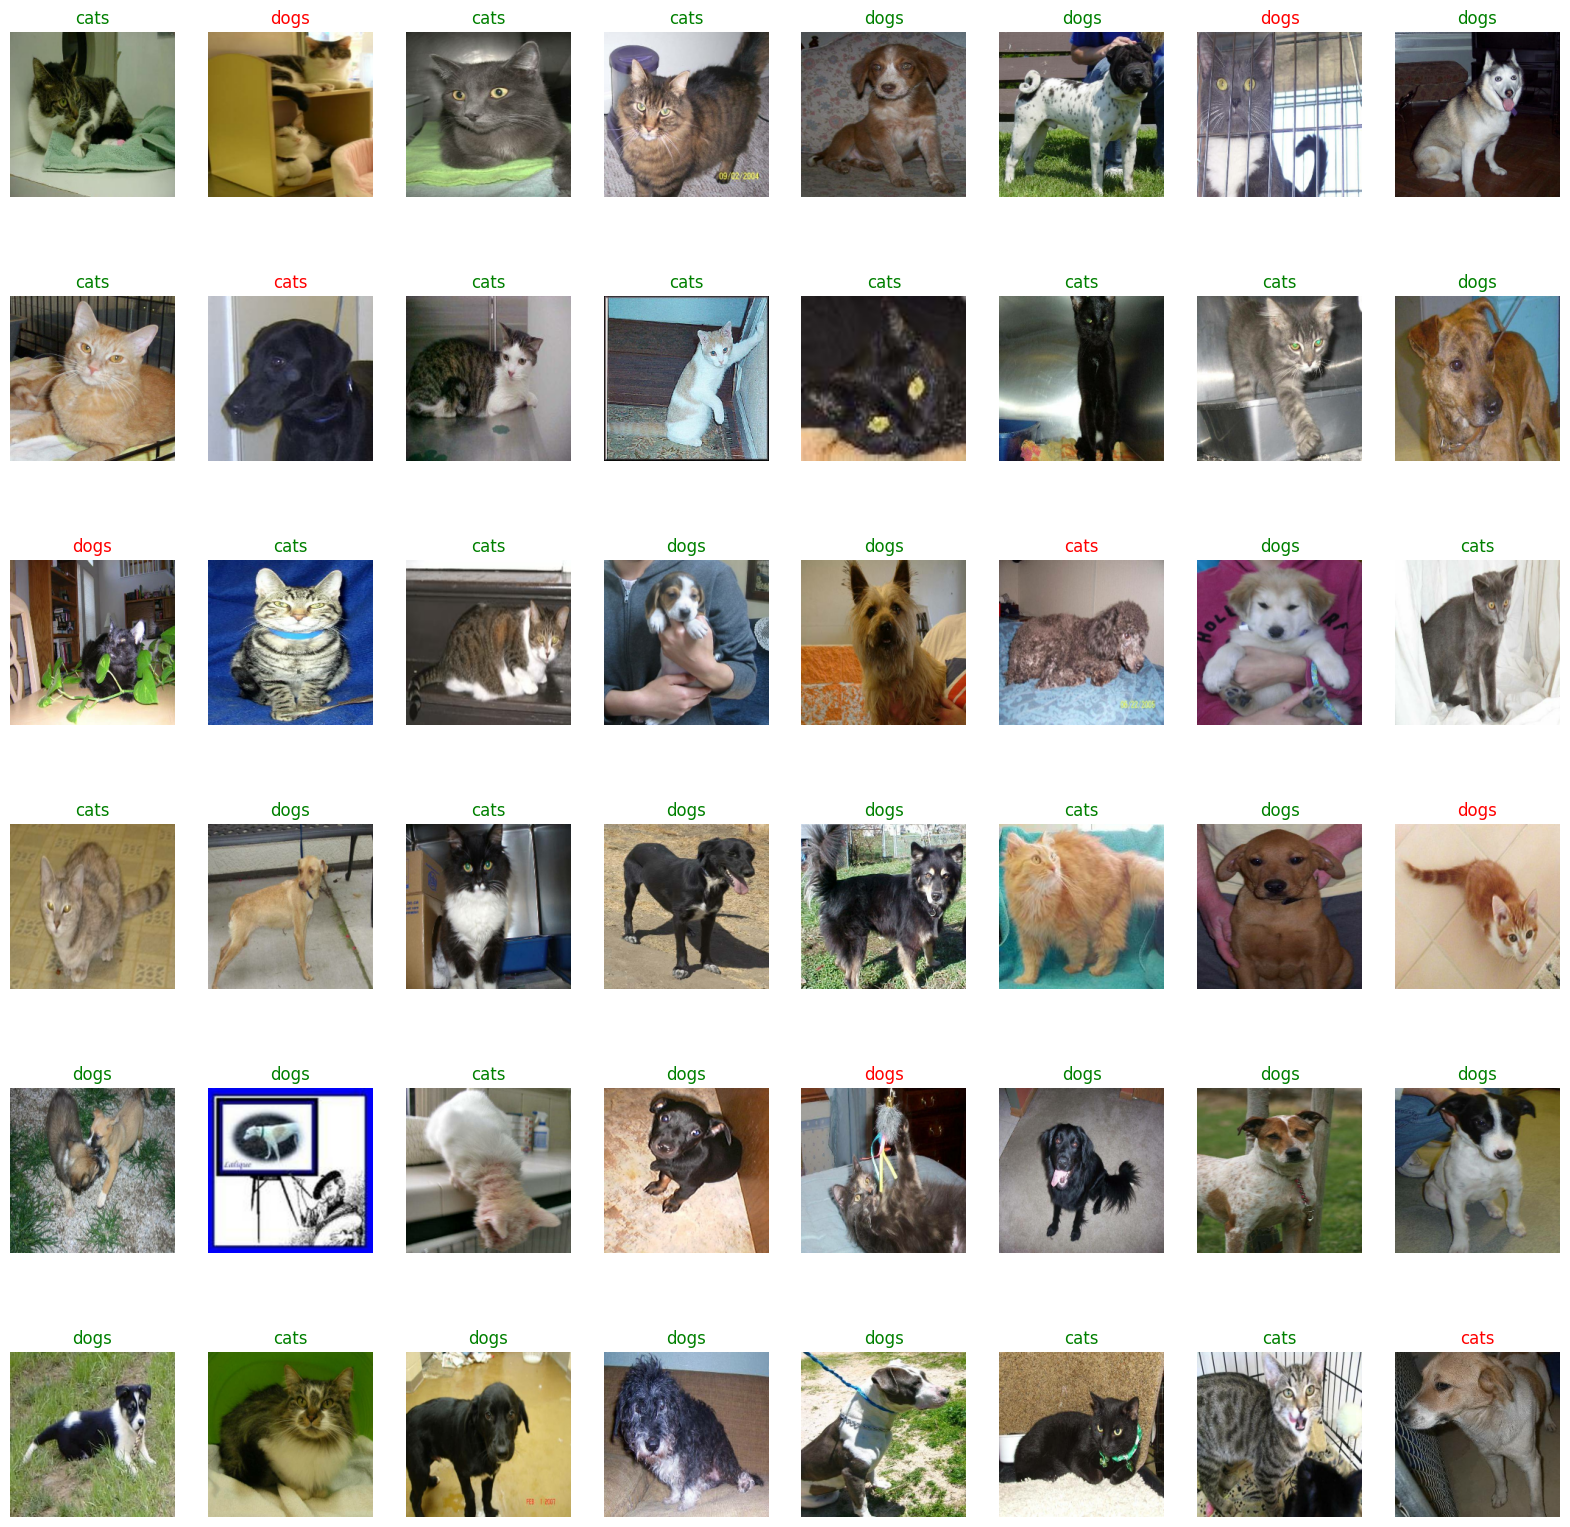

In [19]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    preds_classes = np.argmax(model.predict(images), axis=1)
    for i in range(48):
        ax = plt.subplot(6, 8, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        if preds_classes[i] == labels[i]:
            plt.title(class_names[preds_classes[i]], color='g')
        else:
            plt.title(class_names[preds_classes[i]], color='r')
        plt.axis('off')